In [1]:
import numpy as np
import scipy.stats
import math as math
import autograd.numpy as np
from autograd import grad, jacobian
from scipy import optimize
import pandas as pd

In [2]:
def monod(t):
    x_p = [28, 55, 83, 110, 138, 225, 375]
    return np.array([(t[0] * i) / (t[1] + i) for i in x_p])


def monod_noise(t, noise):
    return np.array([(t[0] * i) / (t[1] + i) + j for i, j in zip(x_p, noise)])


def MAP(t, y):
    return np.linalg.norm(monod(t) - y)


jacobian_monod = jacobian(monod)

In [3]:
x_p = [28, 55, 83, 110, 138, 225, 375]
origin_noise = np.random.normal(0, 0.012, len(x_p))
y = monod_noise(np.array([0.15, 50]), origin_noise)

In [20]:
y

array([0.06677542, 0.07284967, 0.1012225 , 0.11763229, 0.10505076,
       0.1202538 , 0.12407872])

In [4]:
optim = optimize.minimize(MAP, x0=np.array([0.1, 100]), args=(y))
Q = np.linalg.qr(jacobian_monod(optim.x))[0]

In [5]:
def MAP_noise(t, y, Q, noise):
    return (np.linalg.norm(Q.transpose().dot(monod(t) - (y + noise))))**2


def c(t, y, Q):
    return abs(np.linalg.det(Q.transpose().dot(jacobian_monod(t)))) * math.exp(
        0.5 * np.linalg.norm(monod(t) - y)**2 -
        0.5 * np.linalg.norm(Q.transpose().dot(monod(t) - y))**2)

In [6]:
%%time
sample_t0 = []
sample_t1 = []
temp = np.array([0.1, 10])
while len(sample_t0) < 2 * 10e4:
    optim_fun = 1
    while optim_fun >= 10e-8:
        curr_noise = np.random.normal(0, 0.05, len(y))
        optim1 = optimize.minimize(MAP_noise,
                                   x0=optim.x,
                                   args=(y, Q, curr_noise),
                                   tol=10e-16,
                                   bounds=((0, 5), (-10, 1000)))
        optim_fun = optim1.fun
    candid = optim1.x
    r = np.random.uniform(0, 1)
    if r < (abs(temp[0] - optim.x[0]) +
            abs(temp[1] - optim.x[1])**1.25)**0.25 * (c(temp, y, Q) /
                                                      (c(candid, y, Q))):
        sample_t0.append(candid[0])
        sample_t1.append(candid[1])
        temp = candid
    else:
        sample_t0.append(temp[0])
        sample_t1.append(temp[1])

Wall time: 28min 31s


In [23]:
import pandas as pd
sample = pd.DataFrame({'t0': sample_t0, 't1': sample_t1})
sample.to_csv('MONOD.csv')

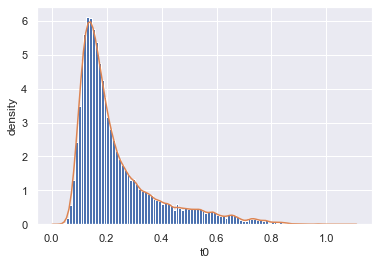

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
p = plt.hist(sample_t0, bins=100, density=True)
plt.xlabel('t0')
plt.ylabel('density')
sns.kdeplot(sample_t0)
plt.show(p)

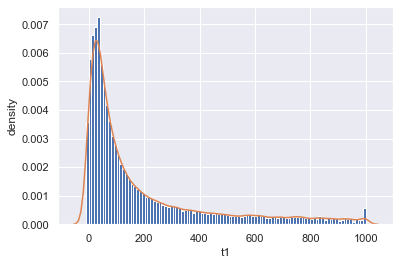

In [19]:
import matplotlib.pyplot as plt
p = plt.hist(sample_t1, bins=100, density=True)
plt.xlabel('t1')
plt.ylabel('density')
sns.kdeplot(sample_t1)
plt.show(p)

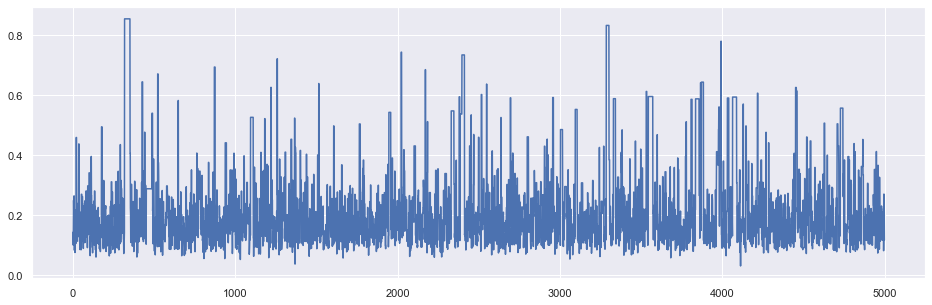

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(sample_t0[0:5000])

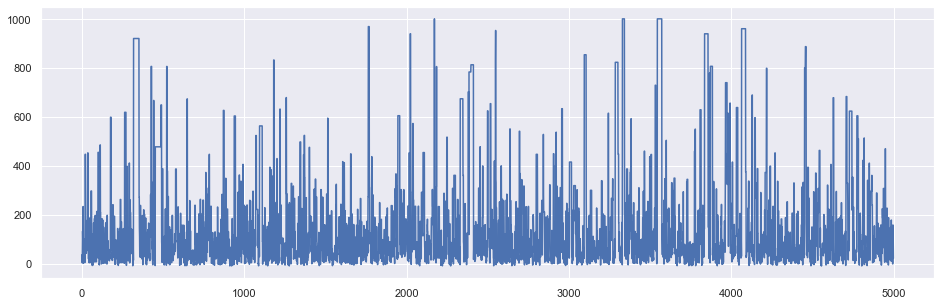

In [10]:
plt.figure(figsize=(16, 5))
plt.plot(sample_t1[0:5000])

C:\Users\Xinyuan Niu\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


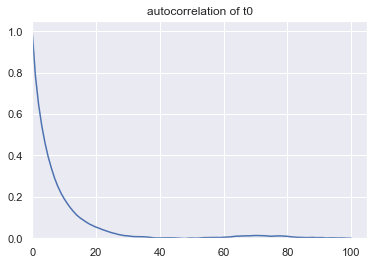

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

plt.plot(acf(sample_t0, nlags=100))
plt.title('autocorrelation of t0')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

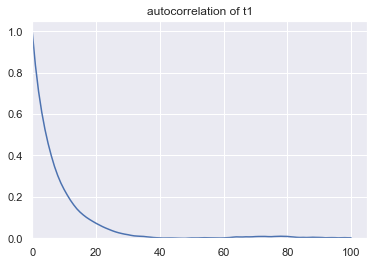

In [12]:
plt.plot(acf(sample_t1, nlags=100))
plt.title('autocorrelation of t1')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

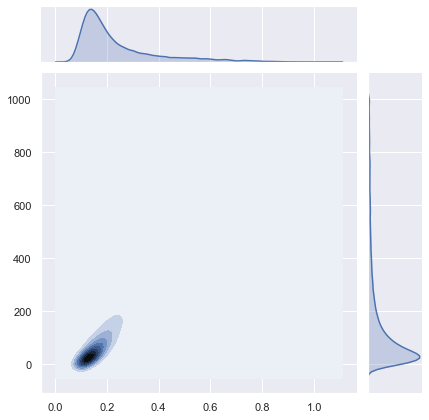

In [13]:
sns.set(color_codes=True)
#sns.set_style("ticks")
contourplot = sns.jointplot(x=sample_t0, y=sample_t1, kind="kde")

In [14]:
sample_df = pd.DataFrame({'t0': sample_t0, 't1': sample_t1})
sub_sample_df = sample_df.loc[(sample_df['t0'] < 0.3)
                              & (sample_df['t1'] < 250)]

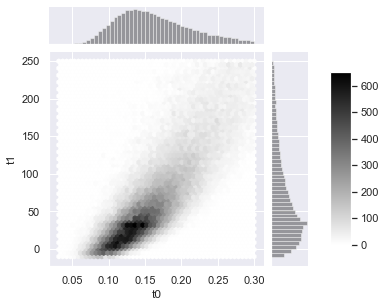

In [15]:
hexplot = sns.jointplot(x=sub_sample_df.t0,
                        y=sub_sample_df.t1,
                        kind="hex",
                        color="k")
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])
plt.colorbar(cax=cbar_ax)
plt.show()

Wall time: 1min 56s


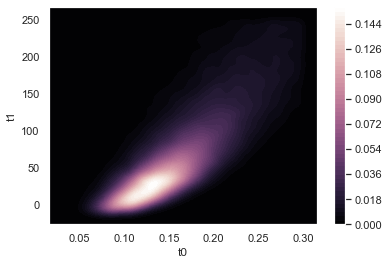

In [16]:
%%time
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(sub_sample_df.t0,
            sub_sample_df.t1,
            cmap=cmap,
            n_levels=60,
            shade=True,
            cbar=True)

In [35]:
import scipy as sp
import numpy as np

deltaX = (max(sub_sample_df.t0) - min(sub_sample_df.t0)) / 10
deltaY = (max(sub_sample_df.t1) - min(sub_sample_df.t1)) / 10
xmin = min(sub_sample_df.t0) - deltaX
xmax = max(sub_sample_df.t0) + deltaX
ymin = min(sub_sample_df.t1) - deltaY
ymax = max(sub_sample_df.t1) + deltaY
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([sub_sample_df.t0, sub_sample_df.t0])
kernel = sp.stats.gaussian_kde(np.vstack([sub_sample_df.t0, sub_sample_df.t1]))
f = np.reshape(kernel(positions).T, xx.shape)

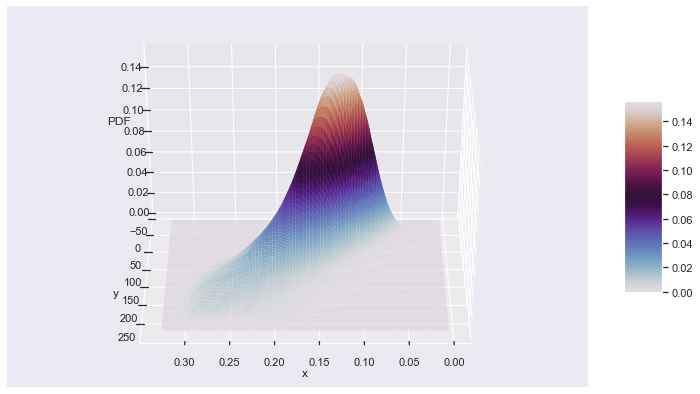

In [211]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx,
                       yy,
                       f,
                       rstride=1,
                       cstride=1,
                       cmap='twilight',
                       edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
fig.colorbar(surf, shrink=0.5, aspect=5)  # add color bar indicating the PDF
ax.view_init(35, 90)

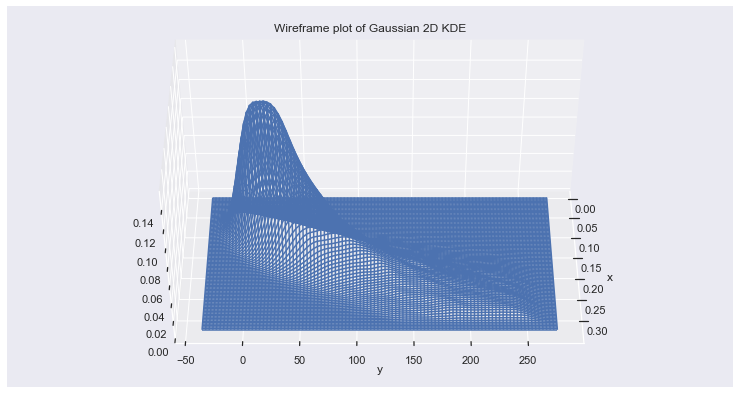

In [190]:
%matplotlib inline
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(xx, yy, f, rstride=1, cstride=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Wireframe plot of Gaussian 2D KDE')
ax.view_init(45, 0)